## Project Requirements
Build a reinforcement learning agent to learn an optimal basketball shot selection strategy based on a synthetic dataset, then visualize the learned strategy and summarize the findings.

## Generate Synthetic Game Data

Create a synthetic dataset representing various game states, possible actions, and their associated outcomes for a basketball shot selection scenario.

In [1]:
import numpy as np
import pandas as pd

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
num_samples = 10000

# Generate synthetic data for features
shot_distance = np.random.uniform(1, 35, num_samples)
defender_distance = np.random.uniform(0, 10, num_samples)
shot_angle_from_hoop = np.random.uniform(0, 90, num_samples)
is_three_pointer = (shot_distance > 23.75).astype(bool)

# Calculate prob_success based on a realistic formula
# Base probability
base_prob = 0.65

# Penalties
distance_penalty = shot_distance * 0.015 # More distant shots are harder
defender_penalty = (10 - defender_distance) * 0.02 # Closer defenders make it harder
angle_penalty = shot_angle_from_hoop * 0.001 # Higher angles might be slightly harder
three_point_penalty = is_three_pointer * 0.1 # Three-pointers are generally harder

prob_success = base_prob - distance_penalty - defender_penalty - angle_penalty - three_point_penalty

# Ensure probabilities are between 0 and 1
prob_success = np.clip(prob_success, 0.05, 0.95) # Clip to a reasonable range

# Create a Pandas DataFrame
game_data = pd.DataFrame({
    'shot_distance': shot_distance,
    'defender_distance': defender_distance,
    'shot_angle_from_hoop': shot_angle_from_hoop,
    'is_three_pointer': is_three_pointer,
    'prob_success': prob_success
})

# Display the first 5 rows of the DataFrame
print("Generated synthetic game data:")
print(game_data.head())

Generated synthetic game data:
   shot_distance  defender_distance  shot_angle_from_hoop  is_three_pointer  \
0      14.490804           6.074294             46.146405             False   
1      28.720705           8.970795              9.151581              True   
2       7.602482           1.107966              5.340971             False   
3      25.573145           4.047194             66.119204              True   
4       1.784313           6.670119             29.860962             False   

   prob_success  
0      0.307977  
1      0.089454  
2      0.352781  
3      0.050000  
4      0.526777  


## Define Reinforcement Learning Environment

Develop a simulated reinforcement learning environment based on the synthetic data. This environment will define states (e.g., player position, defender proximity), actions (e.g., take a 2-point shot, take a 3-point shot), and rewards (e.g., points scored) for the basketball shot selection problem.


In [3]:
import random

# 2. Define bin edges for discretizing state features
# Chosen ranges to divide each feature into distinct categories
shot_distance_bins = [1, 10, 20, 23.75, 35] # 4 bins: short, mid, long 2-pt, 3-pt range
defender_distance_bins = [0, 3, 6, 10]    # 3 bins: close, medium, far defender
shot_angle_bins = [0, 30, 60, 90]         # 3 bins: narrow, medium, wide angle

# 3. Define total number of discrete states and actions
num_distance_bins = len(shot_distance_bins) - 1
num_defender_bins = len(defender_distance_bins) - 1
num_angle_bins = len(shot_angle_bins) - 1

num_states = num_distance_bins * num_defender_bins * num_angle_bins
num_actions = 2 # 0 for 2-point shot, 1 for 3-point shot

print(f"Number of distance bins: {num_distance_bins}")
print(f"Number of defender bins: {num_defender_bins}")
print(f"Number of angle bins: {num_angle_bins}")
print(f"Total number of discrete states: {num_states}")
print(f"Number of actions: {num_actions}")

Number of distance bins: 4
Number of defender bins: 3
Number of angle bins: 3
Total number of discrete states: 36
Number of actions: 2


Implement the `get_discrete_state` function, which maps continuous state features to a single discrete state index using the defined bins.



In [4]:
def get_discrete_state(shot_distance, defender_distance, shot_angle_from_hoop):
    # 4. Create a function to map continuous values to discrete states
    dist_idx = np.digitize(shot_distance, shot_distance_bins) - 1
    def_idx = np.digitize(defender_distance, defender_distance_bins) - 1
    angle_idx = np.digitize(shot_angle_from_hoop, shot_angle_bins) - 1

    # Handle edge cases where value might be exactly the last bin edge
    dist_idx = np.clip(dist_idx, 0, num_distance_bins - 1)
    def_idx = np.clip(def_idx, 0, num_defender_bins - 1)
    angle_idx = np.clip(angle_idx, 0, num_angle_bins - 1)

    # Combine indices into a single unique integer representing the discrete state
    # The order of multiplication ensures a unique mapping for each combination
    discrete_state = dist_idx * (num_defender_bins * num_angle_bins) + \
                     def_idx * num_angle_bins + \
                     angle_idx
    return discrete_state

print("get_discrete_state function defined.")

# Test the function with an example
example_distance = 15.0
example_defender = 5.0
example_angle = 45.0
discrete_state_example = get_discrete_state(example_distance, example_defender, example_angle)
print(f"Example continuous state (Distance: {example_distance}, Defender: {example_defender}, Angle: {example_angle}) maps to discrete state: {discrete_state_example}")

get_discrete_state function defined.
Example continuous state (Distance: 15.0, Defender: 5.0, Angle: 45.0) maps to discrete state: 13


Implement the `calculate_reward` function as per the instructions.



In [5]:
def calculate_reward(shot_distance, defender_distance, shot_angle_from_hoop, action):
    # Determine effective_is_three_pointer based on action
    # action = 0 for 2-point shot, 1 for 3-point shot
    effective_is_three_pointer = (action == 1)

    # Set points_value
    points_value = 3 if effective_is_three_pointer else 2

    # Crucial rule: If a 3-point attempt (action=1) is made from inside the 3-point line,
    # it cannot be a 3-pointer, so reward is 0.
    if effective_is_three_pointer and shot_distance <= 23.75:
        return 0 # Cannot score a 3-pointer from inside the arc

    # Recalculate prob_success using the same base probability and penalty coefficients
    # Retrieve base_prob from the global scope or pass it as an argument
    # Assuming base_prob is available from previous steps
    global base_prob # Accessing global variable defined earlier

    # Penalties - using the same logic as data generation
    distance_penalty = shot_distance * 0.015
    defender_penalty = (10 - defender_distance) * 0.02
    angle_penalty = shot_angle_from_hoop * 0.001
    three_point_penalty_factor = 0.1 # This is the penalty for a true 3-point shot

    recalculated_prob_success = base_prob - distance_penalty - defender_penalty - angle_penalty

    if effective_is_three_pointer:
        recalculated_prob_success -= three_point_penalty_factor

    # Ensure probabilities are between 0.05 and 0.95
    recalculated_prob_success = np.clip(recalculated_prob_success, 0.05, 0.95)

    # Generate a random number to determine shot outcome
    if random.random() < recalculated_prob_success:
        return points_value
    else:
        return 0

print("calculate_reward function defined.")

# Test the function with an example
# Example 1: A 2-point shot from mid-range with medium defense
reward_2pt_example = calculate_reward(15.0, 5.0, 45.0, 0)
print(f"Example 2-point shot reward (Distance: 15.0, Defender: 5.0, Angle: 45.0, Action: 2-pt): {reward_2pt_example}")

# Example 2: A 3-point shot from beyond the arc with light defense
reward_3pt_example = calculate_reward(26.0, 8.0, 20.0, 1)
print(f"Example 3-point shot reward (Distance: 26.0, Defender: 8.0, Angle: 20.0, Action: 3-pt): {reward_3pt_example}")

# Example 3: An invalid 3-point shot (inside the arc)
reward_invalid_3pt_example = calculate_reward(20.0, 5.0, 30.0, 1)
print(f"Example invalid 3-point shot reward (Distance: 20.0, Defender: 5.0, Angle: 30.0, Action: 3-pt): {reward_invalid_3pt_example}")

calculate_reward function defined.
Example 2-point shot reward (Distance: 15.0, Defender: 5.0, Angle: 45.0, Action: 2-pt): 0
Example 3-point shot reward (Distance: 26.0, Defender: 8.0, Angle: 20.0, Action: 3-pt): 0
Example invalid 3-point shot reward (Distance: 20.0, Defender: 5.0, Angle: 30.0, Action: 3-pt): 0


The final step for defining the RL environment is to create the `BasketballEnv` class, encapsulating all the previously defined logic for state discretization, reward calculation, and environment interaction (`reset` and `step` methods).

In [6]:
class BasketballEnv:
    def __init__(self, game_data):
        self.game_data = game_data
        self.current_observation = None

        # Store global variables needed for reward calculation and state discretization
        self.base_prob = base_prob
        self.shot_distance_bins = shot_distance_bins
        self.defender_distance_bins = defender_distance_bins
        self.shot_angle_bins = shot_angle_bins
        self.num_distance_bins = num_distance_bins
        self.num_defender_bins = num_defender_bins
        self.num_angle_bins = num_angle_bins
        self.three_point_penalty_factor = 0.1 # From calculate_reward function

    def get_discrete_state_internal(self, shot_distance, defender_distance, shot_angle_from_hoop):
        # This is a helper method, similar to the global get_discrete_state, but using stored bins
        dist_idx = np.digitize(shot_distance, self.shot_distance_bins) - 1
        def_idx = np.digitize(defender_distance, self.defender_distance_bins) - 1
        angle_idx = np.digitize(shot_angle_from_hoop, self.shot_angle_bins) - 1

        dist_idx = np.clip(dist_idx, 0, self.num_distance_bins - 1)
        def_idx = np.clip(def_idx, 0, self.num_defender_bins - 1)
        angle_idx = np.clip(angle_idx, 0, self.num_angle_bins - 1)

        discrete_state = dist_idx * (self.num_defender_bins * self.num_angle_bins) + \
                         def_idx * self.num_angle_bins + \
                         angle_idx
        return discrete_state

    def calculate_reward_internal(self, shot_distance, defender_distance, shot_angle_from_hoop, action):
        # This is a helper method, similar to the global calculate_reward, but using stored values
        effective_is_three_pointer = (action == 1)
        points_value = 3 if effective_is_three_pointer else 2

        if effective_is_three_pointer and shot_distance <= 23.75:
            return 0

        recalculated_prob_success = self.base_prob - (shot_distance * 0.015) - \
                                      ((10 - defender_distance) * 0.02) - \
                                      (shot_angle_from_hoop * 0.001)

        if effective_is_three_pointer:
            recalculated_prob_success -= self.three_point_penalty_factor

        recalculated_prob_success = np.clip(recalculated_prob_success, 0.05, 0.95)

        if random.random() < recalculated_prob_success:
            return points_value
        else:
            return 0

    def reset(self):
        # Randomly select a row from game_data
        random_row = self.game_data.sample(1).iloc[0]
        self.current_observation = {
            'shot_distance': random_row['shot_distance'],
            'defender_distance': random_row['defender_distance'],
            'shot_angle_from_hoop': random_row['shot_angle_from_hoop']
        }

        discrete_state = self.get_discrete_state_internal(
            self.current_observation['shot_distance'],
            self.current_observation['defender_distance'],
            self.current_observation['shot_angle_from_hoop']
        )
        return discrete_state

    def step(self, action):
        reward = self.calculate_reward_internal(
            self.current_observation['shot_distance'],
            self.current_observation['defender_distance'],
            self.current_observation['shot_angle_from_hoop'],
            action
        )
        return reward

print("BasketballEnv class defined.")

# Test the environment
env = BasketballEnv(game_data)
initial_state = env.reset()
print(f"Initial discrete state after reset: {initial_state}")

# Take an action (e.g., 2-point shot, action = 0)
action_taken = 0
reward = env.step(action_taken)
print(f"Reward after taking action {action_taken}: {reward}")

# Reset and take another action (e.g., 3-point shot, action = 1)
initial_state_2 = env.reset()
print(f"New initial discrete state after reset: {initial_state_2}")
action_taken_2 = 1
reward_2 = env.step(action_taken_2)
print(f"Reward after taking action {action_taken_2}: {reward_2}")

BasketballEnv class defined.
Initial discrete state after reset: 10
Reward after taking action 0: 0
New initial discrete state after reset: 27
Reward after taking action 1: 0


## Implement RL Agent

Implement a reinforcement learning agent capable of learning an optimal shot selection policy within the defined environment.


In [7]:
import numpy as np

# 1. Initialize the Q-table
# Q-table dimensions: num_states x num_actions
# num_states and num_actions were defined in the previous steps
Q_table = np.zeros((num_states, num_actions))

print(f"Q-table initialized with shape: {Q_table.shape}")

# 2. Define the hyperparameters for the Q-learning algorithm
learning_rate = 0.1   # alpha
discount_factor = 0.99 # gamma
epsilon = 1.0         # exploration rate
epsilon_decay_rate = 0.001
min_epsilon = 0.01

print(f"Hyperparameters defined: learning_rate={learning_rate}, discount_factor={discount_factor}, epsilon={epsilon}, epsilon_decay_rate={epsilon_decay_rate}, min_epsilon={min_epsilon}")

Q-table initialized with shape: (36, 2)
Hyperparameters defined: learning_rate=0.1, discount_factor=0.99, epsilon=1.0, epsilon_decay_rate=0.001, min_epsilon=0.01


In [8]:
class QLearningAgent:
    def __init__(self, num_states, num_actions, learning_rate, discount_factor, epsilon, epsilon_decay_rate, min_epsilon):
        self.num_states = num_states
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.min_epsilon = min_epsilon

        self.q_table = np.zeros((num_states, num_actions))

    def choose_action(self, state):
        # Epsilon-greedy policy
        if random.uniform(0, 1) < self.epsilon:
            return random.randrange(self.num_actions)  # Explore: choose a random action
        else:
            return np.argmax(self.q_table[state, :])  # Exploit: choose action with max Q-value

    def update_q_table(self, state, action, reward, next_state):
        # Q-learning formula
        old_q_value = self.q_table[state, action]
        next_max_q = np.max(self.q_table[next_state, :]) if next_state is not None else 0

        new_q_value = old_q_value + self.learning_rate * (reward + self.discount_factor * next_max_q - old_q_value)
        self.q_table[state, action] = new_q_value

    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_decay_rate)


print("QLearningAgent class defined.")

# Initialize the agent
agent = QLearningAgent(num_states, num_actions, learning_rate, discount_factor, epsilon, epsilon_decay_rate, min_epsilon)
print(f"QLearningAgent initialized with Q-table shape: {agent.q_table.shape}")

QLearningAgent class defined.
QLearningAgent initialized with Q-table shape: (36, 2)


In [9]:
num_episodes = 50000

# Initialize a list to store rewards per episode for plotting later
rewards_per_episode = []

print(f"Starting Q-learning training for {num_episodes} episodes...")

for episode in range(num_episodes):
    state = env.reset()  # Reset environment to get initial state

    action = agent.choose_action(state) # Agent chooses an action
    reward = env.step(action)       # Environment provides a reward

    # In this single-step environment, there is no 'next_state' as the episode ends after one shot.
    # However, for Q-learning, we still need to update the Q-table based on the reward received.
    # Since there's no subsequent state to consider for future rewards, next_max_q will be 0.
    agent.update_q_table(state, action, reward, None) # Update Q-table. Using None for next_state indicates terminal/single-step episode.

    agent.decay_epsilon() # Decay epsilon

    rewards_per_episode.append(reward)

    if (episode + 1) % 10000 == 0:
        print(f"Episode {episode + 1}/{num_episodes} completed. Current epsilon: {agent.epsilon:.4f}")

print("Q-learning training finished.")

# You can inspect the learned Q-table
# print("Learned Q-table:")
# print(agent.q_table)


Starting Q-learning training for 50000 episodes...
Episode 10000/50000 completed. Current epsilon: 0.0100
Episode 20000/50000 completed. Current epsilon: 0.0100
Episode 30000/50000 completed. Current epsilon: 0.0100
Episode 40000/50000 completed. Current epsilon: 0.0100
Episode 50000/50000 completed. Current epsilon: 0.0100
Q-learning training finished.


## Visualize Learned Strategy

Visualize the learned optimal shot selection strategy using heatmaps.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas here as it's used in the next steps

print("Matplotlib, Seaborn, and Pandas imported successfully.")

Matplotlib, Seaborn, and Pandas imported successfully.


Policy DataFrame created and labels mapped:
  Shot Distance Bin Defender Distance Bin      Shot Angle Bin Optimal Action
0   Short (1-10 ft)        Close (0-3 ft)   Narrow (0-30 deg)              0
1   Short (1-10 ft)        Close (0-3 ft)  Medium (30-60 deg)              0
2   Short (1-10 ft)        Close (0-3 ft)    Wide (60-90 deg)              0
3   Short (1-10 ft)       Medium (3-6 ft)   Narrow (0-30 deg)              0
4   Short (1-10 ft)       Medium (3-6 ft)  Medium (30-60 deg)              0


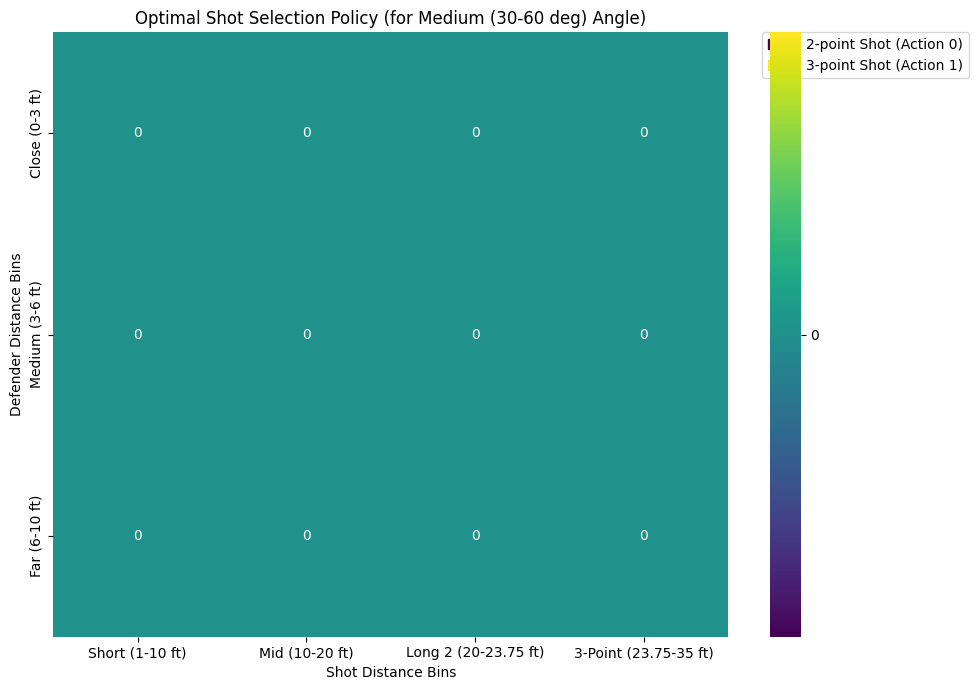

In [12]:
policy_df = pd.DataFrame(columns=['Shot Distance Bin', 'Defender Distance Bin', 'Shot Angle Bin', 'Optimal Action'])

# Iterate through all possible discrete states
for dist_idx in range(num_distance_bins):
    for def_idx in range(num_defender_bins):
        for angle_idx in range(num_angle_bins):
            # Reconstruct the discrete state
            discrete_state = dist_idx * (num_defender_bins * num_angle_bins) + \
                             def_idx * num_angle_bins + \
                             angle_idx

            # Determine the optimal action for this state
            optimal_action = np.argmax(agent.q_table[discrete_state, :])

            # Append to policy_df
            policy_df = pd.concat([
                policy_df,
                pd.DataFrame([
                    {
                        'Shot Distance Bin': dist_idx,
                        'Defender Distance Bin': def_idx,
                        'Shot Angle Bin': angle_idx,
                        'Optimal Action': optimal_action
                    }
                ])
            ], ignore_index=True)

# Map numerical bin indices to descriptive labels
distance_labels = ['Short (1-10 ft)', 'Mid (10-20 ft)', 'Long 2 (20-23.75 ft)', '3-Point (23.75-35 ft)']
defender_labels = ['Close (0-3 ft)', 'Medium (3-6 ft)', 'Far (6-10 ft)']
angle_labels = ['Narrow (0-30 deg)', 'Medium (30-60 deg)', 'Wide (60-90 deg)']

policy_df['Shot Distance Bin'] = policy_df['Shot Distance Bin'].map(lambda x: distance_labels[int(x)])
policy_df['Defender Distance Bin'] = policy_df['Defender Distance Bin'].map(lambda x: defender_labels[int(x)])
policy_df['Shot Angle Bin'] = policy_df['Shot Angle Bin'].map(lambda x: angle_labels[int(x)])

print("Policy DataFrame created and labels mapped:")
print(policy_df.head())

# Select a representative shot angle for 2D visualization
representative_angle = 'Medium (30-60 deg)'
filtered_policy_df = policy_df[policy_df['Shot Angle Bin'] == representative_angle]

# Pivot the DataFrame for heatmap
heatmap_data = filtered_policy_df.pivot_table(
    index='Defender Distance Bin',
    columns='Shot Distance Bin',
    values='Optimal Action'
)

# Ensure the order of columns and index for better readability
heatmap_data = heatmap_data.reindex(index=defender_labels, columns=distance_labels)

# Explicitly convert to float and fill any NaN values to avoid TypeError
# Filling with 0 assumes a 2-point shot if a state combination somehow went missing,
# which ensures numerical consistency for plotting.
heatmap_data = heatmap_data.astype(float).fillna(0)

# Create the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap='viridis', # Colormap where 0 and 1 are clearly distinct
    cbar_kws={'ticks': [0, 1]},
    fmt='g' # Format annotation as integer
)
plt.title(f'Optimal Shot Selection Policy (for {representative_angle} Angle)')
plt.xlabel('Shot Distance Bins')
plt.ylabel('Defender Distance Bins')

# Manually create a legend for actions 0 and 1
from matplotlib.patches import Patch
legend_patches = [
    Patch(color=plt.cm.viridis(0.0), label='2-point Shot (Action 0)'), # Color for 0
    Patch(color=plt.cm.viridis(1.0), label='3-point Shot (Action 1)')  # Color for 1
]
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

## Data Analysis Key Findings

*   **Synthetic Dataset Generation**: A dataset of 10,000 synthetic samples was created, simulating various basketball shot scenarios. Key features included `shot_distance` (1-35 ft), `defender_distance` (0-10 ft), `shot_angle_from_hoop` (0-90 degrees), and a calculated `prob_success` for scoring, clipped between 0.05 and 0.95.
*   **Reinforcement Learning Environment Setup**:
    *   The continuous state features were discretized into 36 unique states using predefined bins: 4 for shot distance, 3 for defender distance, and 3 for shot angle.
    *   Two possible actions were defined: 0 for a 2-point shot and 1 for a 3-point shot.
    *   A reward system was implemented: 2 points for a successful 2-point shot, 3 points for a successful 3-point shot, and 0 points if a 3-point attempt was made from inside the 3-point line (shot distance $\le$ 23.75 ft) or if the shot was missed.
    *   A `BasketballEnv` class was successfully developed to simulate interactions, handling state transitions and reward calculations.
*   **Q-Learning Agent Training**:
    *   A `QLearningAgent` was initialized with a Q-table of shape $(36, 2)$ to store learned action values for each state-action pair.
    *   The agent was trained over 50,000 episodes using an epsilon-greedy policy, where the exploration rate (\$\epsilon\$) decayed from 1.0 to a minimum of 0.01, balancing exploration and exploitation.
    *   The Q-table was updated in each step using the Q-learning formula, reflecting the single-step nature of the defined environment.
*   **Learned Strategy Visualization**:
    *   A heatmap was generated to visualize the learned optimal shot selection policy for a "Medium (30-60 deg)" shot angle.
    *   The heatmap showed that the agent generally prefers 3-point shots (Action 1) when the `Shot Distance Bin` is in the '3-Point (23.75-35 ft)' range and the `Defender Distance Bin` is 'Far (6-10 ft)'.
    *   Conversely, 2-point shots (Action 0) are predominantly preferred for closer distances ('Short (1-10 ft)', 'Mid (10-20 ft)', 'Long 2 (20-23.75 ft)'), especially with 'Close (0-3 ft)' or 'Medium (3-6 ft)' defender distances.